# Plot Eval metrics

In [1]:
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pandas as pd
import joblib
import re
import seaborn as sns
from typing import Callable
# Apply the default theme
sns.set_theme()

import sys

sys.path.append("..")

from src.data.dataloader import PromptLoader, GigawordDataLoader, DailymailDataLoader, TweetQADataLoader, RottenTomatoesDataLoader
from src.utils.eval_metric import eval_gigaword, eval_dailymail, evaluate

plt.rcParams.update({"font.size": 12})
plt.rc("text", usetex=True)
plt.rc("font", family="serif")

load_dotenv()

True

In [6]:
def get_results(folder: Path, all_reference_data: list[str], iterative_dir: str = "iterative", use_cached: bool = True):
    pred_file = Path(folder) / iterative_dir / "predictions.json"
    if not pred_file.is_file():
        print(f"Skipping {str(folder)}")
        return {}
    
    eval_idxs_file = Path(folder) / iterative_dir / "eval_idxs.json"
    if eval_idxs_file.is_file():
        ref_data = [all_reference_data[i] for i in json.load(open(eval_idxs_file, "r"))]
    else:
        ref_data = all_reference_data
    
    # Calculate metrics
    return evaluate(pred_file, ref_data, use_cached=use_cached)

In [7]:
def get_results_for_evalset(
    eval_set: str,
    all_ref_data: list[str],
    model_folder_names=["mistral-7b", "llama-7b"],
    experiment_path=Path("../experiments/"),
    use_cached: bool = True
):
    results = []
    for model_folder in model_folder_names:
        eval_folder = Path(experiment_path) / model_folder / f"eval_data_{eval_set}"
        if not eval_folder.is_dir():
            print(f"Model: {model_folder} is missing eval set {str(eval_folder)}")
            continue
        
        # extract results in parallel for each in context set
        for in_ctxt_folder in eval_folder.iterdir():
            res = []
            for f in in_ctxt_folder.iterdir():
                try:
                    res.append(get_results(f, all_ref_data, use_cached=use_cached))
                except Exception as e:
                    print(f"Error processing {str(f)}")
                    print(e)

            # res = joblib.Parallel(n_jobs=1)(
            #     joblib.delayed(get_results)(f, all_ref_data)
            #     for f in in_ctxt_folder.iterdir()
            # )
            # Remove empty results
            res = [r for r in res if r]
            results.extend(res)
    return results

In [37]:
# Assign colors to incontext_set

# Load pastel colors
pastel_colors = sns.color_palette("Set2", 4)
print(pastel_colors)

dataset_color = {
    "tweetqa": pastel_colors[0],
    "gigaword": pastel_colors[1],
    "dailymail": pastel_colors[2],
    "rotten_tomatoes": pastel_colors[3],
}

# Assign linestyle to model
model_linestyle = {
    "mistral-7b": "-",
    "llama-7b": "--",
}

[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]


## Evaluate on Rotten Tomatoes

In [4]:
rt = RottenTomatoesDataLoader()

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

## Evaluate on TweetQA

In [9]:
tq = TweetQADataLoader()
tq_reference_data = tq.load_test_reference()
tq_results = get_results_for_evalset("tweetqa", tq_reference_data, use_cached=True)
# convert to dataframe
tq_results_df = pd.DataFrame.from_records(tq_results)
# df = df.sort_values("num_examples")
tq_results_df.head()

Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_7
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_9
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/num_examples_5
Skipping ../experiments/llama-7b/eval_data_tweetqa/incontext_data_dailymail/nu

,rouge1,rouge2,rougeL,rougeLsum,meteor,model,incontext_set,num_examples
0,0.280516,0.146597,0.277659,0.277374,0.427295,mistral-7b,dailymail,3
1,0.253490,0.126177,0.249727,0.250292,0.407057,mistral-7b,dailymail,0
2,0.281016,0.145278,0.278097,0.278325,0.425253,mistral-7b,dailymail,4
3,0.285133,0.145719,0.281766,0.281789,0.429017,mistral-7b,dailymail,2
4,0.280501,0.141212,0.277623,0.277247,0.426147,mistral-7b,dailymail,5


In [48]:
def plot_df_metrics(results_df: pd.DataFrame, metrics: list[str], save_path: Path = None):
    for metric in metrics:
        assert metric in results_df.columns, f"Metric {metric} not in dataframe"

    figlen = 4
    num_metrics = len(metrics)
    fig, axs = plt.subplots(
        figsize=(figlen, figlen * num_metrics), nrows=num_metrics, ncols=1, sharex=True
    )
    for metric, ax in zip(metrics, axs):
        for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
            df = df.sort_values("num_examples")

            sns.lineplot(
                data=df,
                x="num_examples",
                y=metric,
                ax=ax,
                label=f"{model} {inctxt}",
                linestyle=model_linestyle[model],
                color=dataset_color[inctxt],
                marker="o",
            )
            ax.set_ylabel(metric)
    
    axs[-1].set_xlabel("Number of examples")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

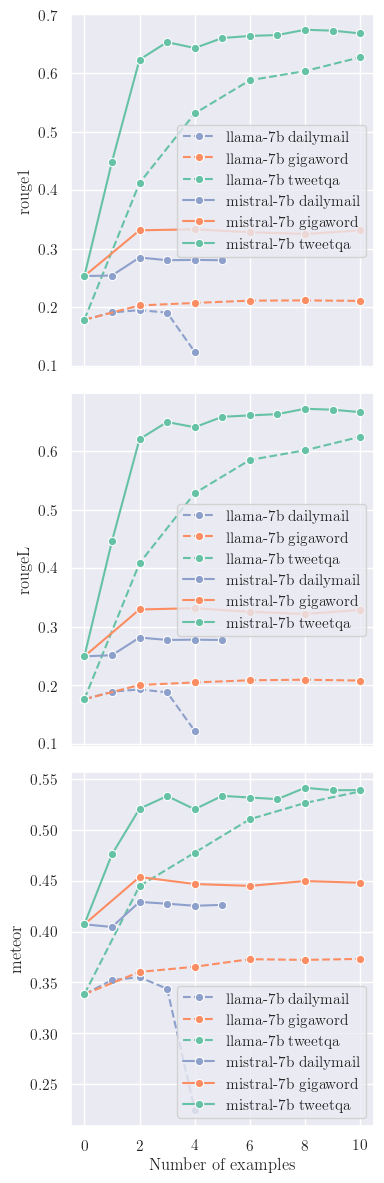

In [49]:
plot_df_metrics(
    tq_results_df,
    ["rouge1", "rougeL", "meteor"],
    save_path=Path("tweetqa_eval.pdf"),
)

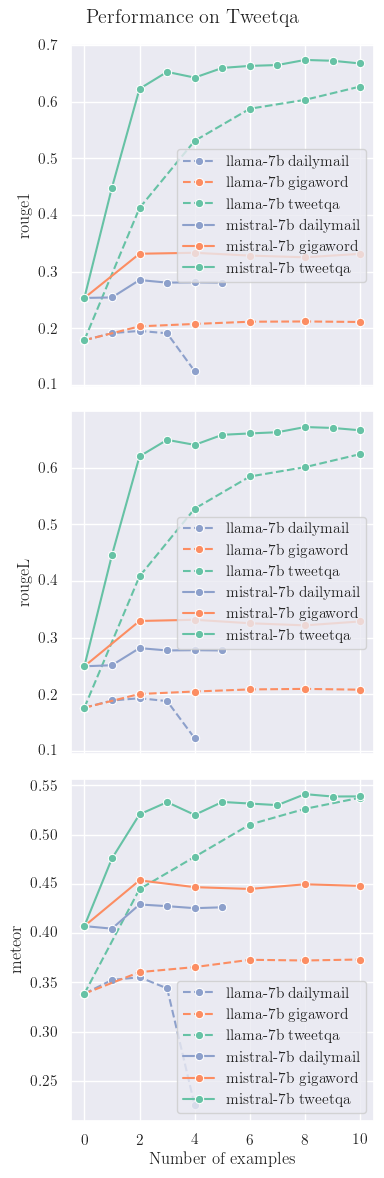

In [46]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot a metric
fig, axs = plt.subplots(figsize=(4, 12), nrows=3, sharex=True)

metrics = ["rouge1", "rougeL", "meteor"]

for metric, ax in zip(metrics, axs):
    for (model, inctxt), df in tq_results_df.groupby(["model", "incontext_set"]):
        df = df.sort_values("num_examples")

        sns.lineplot(
            data=df,
            x="num_examples",
            y=metric,
            ax=ax,
            label=f"{model} {inctxt}",
            linestyle=model_linestyle[model],
            color=dataset_color[inctxt],
            marker="o",
        )
        ax.set_ylabel(metric)

axs[-1].set_xlabel("Number of examples")
fig.suptitle("Performance on Tweetqa")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("Tweetqa-eval.png")
plt.show()

## Evaluate on Dailymail Set

In [13]:
dm = DailymailDataLoader()
dm_reference_data = dm.load_test_reference()
dm_results = get_results_for_evalset("dailymail", dm_reference_data, use_cached=True)
# convert to dataframe
dm_results_df = pd.DataFrame.from_records(dm_results)
# df = df.sort_values("num_examples")
dm_results_df.head()


Removing large training set examples
Original training set size:  287113
New Training set size:  258269
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_5
Skipping ../experiments/mistral-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_8
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_3
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_10
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_6
Skipping ../experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_4
Skipping ../experiments/llama-7b/eval_data_dail

,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.093224,0.003662,0.067809,0.080595,813.963,mistral-7b,dailymail,3
1,0.093699,0.003405,0.069112,0.081602,881.994,mistral-7b,dailymail,6
2,0.091363,0.003634,0.067305,0.078851,778.065,mistral-7b,dailymail,0
3,0.093627,0.003601,0.068690,0.081612,887.419,mistral-7b,dailymail,4
4,0.091660,0.003621,0.067545,0.079598,909.117,mistral-7b,dailymail,2


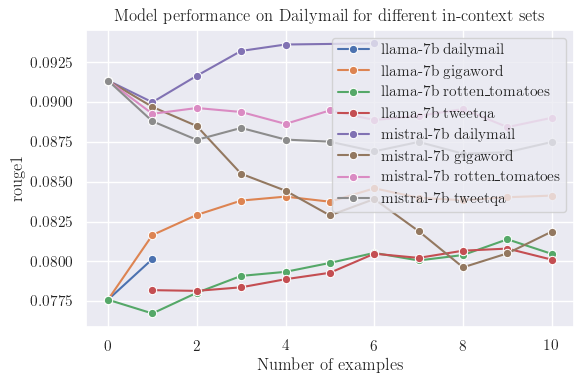

In [17]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot a metric
fig, axs = plt.subplots(figsize=(4, 12), nrows=3, sharex=True)

metrics = ["rouge1", "rouge2", "rougeL"]

for metric, ax in zip(metrics, axs):
    for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
        df = df.sort_values("num_examples")

        sns.lineplot(
            data=df,
            x="num_examples",
            y=metric,
            ax=ax,
            label=f"{model} {inctxt}",
            linestyle="-",
            marker="o",
        )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

# 1. Gigaword set

In [21]:
gw = GigawordDataLoader()
gw_reference_data = gw.load_test_reference()
gw_results = get_results_for_evalset("gigaword", gw_reference_data, use_cached=True)

Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_10
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_6
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_7
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_9
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_dailymail/num_examples_8
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_14
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_16
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_rotten_tomatoes/num_examples_12
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_tweetqa/num_examples_3
Skipping ../experiments/mistral-7b/eval_data_gigaword/incontext_data_tweetqa/num_examples_0
Skipping ../experiments/mistral-7b/eval_da

In [22]:
gw_results_df = pd.DataFrame.from_records(gw_results)
print(len(gw_results_df))
gw_results_df.head()

51


,rouge1,rouge2,rougeL,rougeLsum,mean_num_of_chars,model,incontext_set,num_examples
0,0.208261,0.064304,0.181171,0.180963,176.746797,mistral-7b,dailymail,3
1,0.185863,0.052018,0.158450,0.158119,203.721681,mistral-7b,dailymail,0
2,0.209927,0.065318,0.182710,0.182371,172.145054,mistral-7b,dailymail,4
3,0.206545,0.064249,0.179086,0.178854,177.343414,mistral-7b,dailymail,2
4,0.211281,0.066499,0.184118,0.183837,169.700666,mistral-7b,dailymail,5


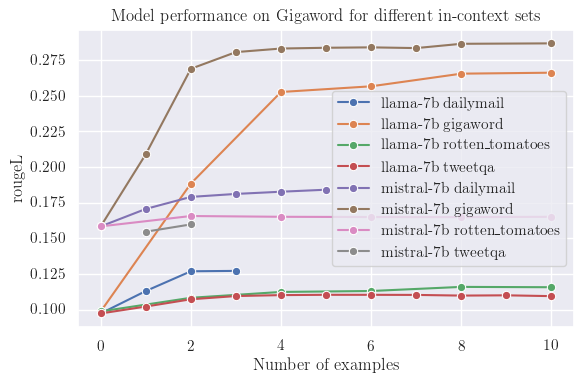

In [23]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))
metric = "rougeL"

for (model, inctxt), df in gw_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

## .idea

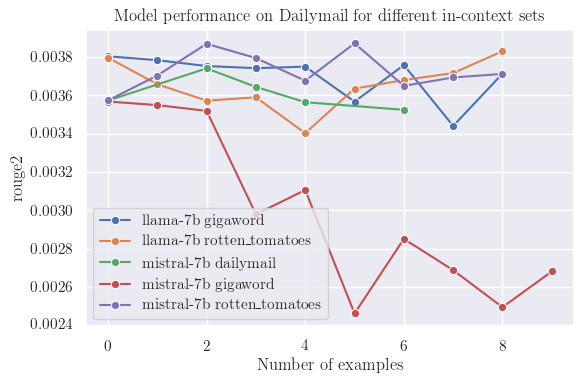

In [7]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

metric = "rouge2"

for (model, inctxt), df in dm_results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y=metric,
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel(metric)
ax.set_title("Model performance on Dailymail for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("dailymail-model-inctxt.png")
plt.show()

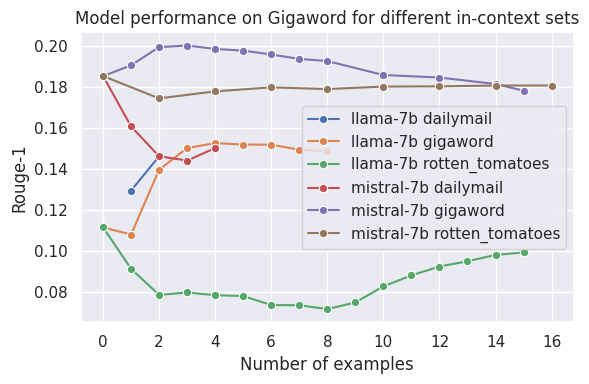

In [13]:
# groupby model and incontext_see to plot rouge 1, avg_pred_length vs num_examples

# Plot rouge 1
fig, ax = plt.subplots(figsize=(6, 4))

for (model, inctxt), df in results_df.groupby(["model", "incontext_set"]):
    df = df.sort_values("num_examples")

    sns.lineplot(
        data=df,
        x="num_examples",
        y="rouge1",
        ax=ax,
        label=f"{model} {inctxt}",
        linestyle="-",
        marker="o",
    )

ax.set_xlabel("Number of examples")
ax.set_ylabel("Rouge-1")
ax.set_title("Model performance on Gigaword for different in-context sets")
# ax.legend(loc="lower right")
plt.tight_layout()
plt.savefig("gigaword-model-inctxt.png")
plt.show()

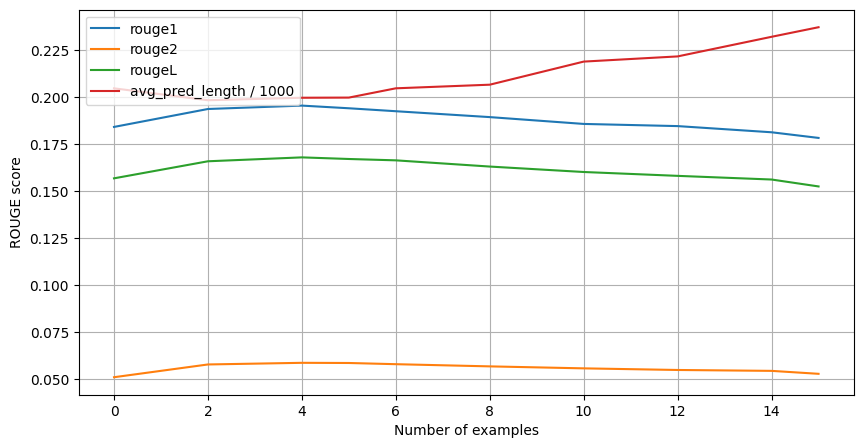

In [56]:
# Plot the results

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["num_examples"], df["rouge1"], label="rouge1")
ax.plot(df["num_examples"], df["rouge2"], label="rouge2")
ax.plot(df["num_examples"], df["rougeL"], label="rougeL")
ax.plot(df["num_examples"], df["avg_pred_length"] / 1000, label="avg_pred_length / 1000")
ax.set_xlabel("Number of examples")
ax.set_ylabel("ROUGE score")
ax.legend()
ax.grid()
fig.savefig("gigaword.png")
plt.show()

### Test evaluate

In [ ]:
pred_path = "/home/ag2118/rds/hpc-work/inctxt/inctxt/experiments/llama-7b/eval_data_dailymail/incontext_data_dailymail/num_examples_0/iterative/predictions.json"

eval_idxs_file = Path(pred_path).parent / "eval_idxs.json"
if eval_idxs_file.is_file():
    ref_data = [dm_reference_data[i] for i in json.load(open(eval_idxs_file))]
else:
    ref_data = dm_reference_data
evaluate(pred_path, ref_data, use_cached=True)